# Phylogenetic distance vs cell size and other genome properties

### This notebook will assess the idea of phylogenetic signal (closely related species tend to have similar values for a given trait more than expected by chance) by looking at the raw data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from skbio import TreeNode, DistanceMatrix
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import spearmanr, pearsonr
from skbio.stats.distance import mantel
from scipy.stats.mstats import winsorize
import seaborn as sns
from matplotlib import colors as colorsm

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import norm, kstest, kruskal, levene

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [5]:
# %matplotlib notebook

Load data

In [6]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df.shape

(5380, 22)

In [7]:
df['svratio'] = df['volume'] / df['surface']
df['log_svratio'] = np.log10(df['svratio'])

Load tree

In [8]:
tree = TreeNode.read('../phylogeny/place/fine_all.nwk')
tree.count(tips = True)

5380

Calculate tip-to-tip distances

In [9]:
dm = tree.tip_tip_distances()
dm.shape

(5380, 5380)

The difference in distance for every pair is calculated as follows:
1. $\lvert a - b \rvert$

2. $\frac{\lvert a - b \rvert}{a + b}$

3. $\frac{\lvert a - b \rvert}{\text{max} - \text{min}}$

* Metric 2 calculates differences in size of a pair and divides it by the sum of their sizes, we call this **relative difference.**

* Metric 3 also calculates the difference in size of a pair but such a difference is normalized by the difference between the maximum size and the minimun size. 

Both metrics produce values that are bounded between 0 and 1, which are easy to interpret: 1 indicates that two species have extremely different sizes and 0 indicates two species with very similar sizes. Nonetheless, as Ferran pointed out, metric 2 has some disadvantages, see Table.

|  | Metric 2 | Metric 3 |
|---|---|---|
| Normalized$^{a}$ | No | Yes |
| Allow comparison across pairs | No | Yes |
| Robust against outliers | Yes | No |
| All values are treated in the same way$^{b}$ | No | Yes |

$^{a}$Metric 2 is not normalized because each pair is divided by a different values (the sum of sizes in a pair). Therefore, comparison across pairs is not fair.  
${^b}$Metric 2 is more sensitive to differences in size between small values. For example suppose an array $X = \{1, ..., 100 \}$ containing cell sizes, and the pairs \(1, 2\), \(1, 3\), \(100, 2\), and \(100, 3\). The difference for each pair is

|  | Metric 2 | Metric 3 |
|---|---|---|
| (1, 2) | 0.33 | 0.01 |
| (1, 3) | 0.5 | 0.02 |
| (100, 2) | 0.96 | 0.98 |
| (100, 3) | 0.94 | 0.97 |

Note that pairs (1, 2) and (1, 3) is 0.17, while between pairs (100, 2) and (100, 3) is 0.02. For metric 3 the differences between pairs is constant (0.01) regardless of the individual values. **To summarize**, metric 2 is more sensitive to differences between small values, while metric 3 treats all values in the same way. 

**A log-transformation of the cell sizes before calculating the relative differences solves the 'outliers issues' with metric 2!**

Get distances between every pair of tip

In [10]:
df = df.loc[list(dm.ids)]

In [11]:
idx = df.index.tolist()

## Test

In [12]:
x = np.array([0.1, 0.5, 10, 15, 100, 110])
x_log = np.log10(x)

In [13]:
x_max = np.max(x_log)
x_min = np.min(x_log)
x_mean = np.mean(x_log)

Different normalization methods

In [14]:
for i, j in combinations(range(len(x_log)), 2):
    a = x_log[i]
    b = x_log[j]
    rd = np.abs(a - b) / (np.abs(a) + np.abs(b))
    rd_ = np.abs(b - a) / (np.abs(b) + np.abs(a))
    rd_2 = np.abs(a - b) / (x_max - x_min)
    rd_3 = np.abs(a - b) / np.abs(x_mean)
    print(f'Pair: ({a:.2f}, {b:.2f}) rd: {rd:.2f}, rd_: {rd_:.2f}, rd_2: {rd_2:.2f}, rd_3: {rd_3:.2f}')

Pair: (-1.00, -0.30) rd: 0.54, rd_: 0.54, rd_2: 0.23, rd_3: 0.85
Pair: (-1.00, 1.00) rd: 1.00, rd_: 1.00, rd_2: 0.66, rd_3: 2.44
Pair: (-1.00, 1.18) rd: 1.00, rd_: 1.00, rd_2: 0.72, rd_3: 2.66
Pair: (-1.00, 2.00) rd: 1.00, rd_: 1.00, rd_2: 0.99, rd_3: 3.66
Pair: (-1.00, 2.04) rd: 1.00, rd_: 1.00, rd_2: 1.00, rd_3: 3.71
Pair: (-0.30, 1.00) rd: 1.00, rd_: 1.00, rd_2: 0.43, rd_3: 1.59
Pair: (-0.30, 1.18) rd: 1.00, rd_: 1.00, rd_2: 0.49, rd_3: 1.80
Pair: (-0.30, 2.00) rd: 1.00, rd_: 1.00, rd_2: 0.76, rd_3: 2.81
Pair: (-0.30, 2.04) rd: 1.00, rd_: 1.00, rd_2: 0.77, rd_3: 2.86
Pair: (1.00, 1.18) rd: 0.08, rd_: 0.08, rd_2: 0.06, rd_3: 0.21
Pair: (1.00, 2.00) rd: 0.33, rd_: 0.33, rd_2: 0.33, rd_3: 1.22
Pair: (1.00, 2.04) rd: 0.34, rd_: 0.34, rd_2: 0.34, rd_3: 1.27
Pair: (1.18, 2.00) rd: 0.26, rd_: 0.26, rd_2: 0.27, rd_3: 1.01
Pair: (1.18, 2.04) rd: 0.27, rd_: 0.27, rd_2: 0.28, rd_3: 1.06
Pair: (2.00, 2.04) rd: 0.01, rd_: 0.01, rd_2: 0.01, rd_3: 0.05


**Notice that after log-transformation `rd` saturates for pairs with large differences, whereas `r2_2` does not and quantifies the differences more accurately**

## Raw data

Takes some time to run

In [15]:
# mu = np.mean(df['log_svratio'])
# max_size = np.max(df['log_svratio'])
# min_size = np.min(df['log_svratio'])

In [16]:
# %%time
# tmp = {}
# tmp['pd_dist'] = dm.condensed_form()
# # for prop in ['svratio', 'genome', 'proteins', 'gc']:
# for prop in ['log_svratio']:
#     s = df[prop].values
#     dm0 = DistanceMatrix.from_iterable(s, lambda a, b: np.abs(a - b), keys = idx, validate = False).condensed_form()
#     dm1 = DistanceMatrix.from_iterable(s, lambda a, b: np.abs(a - b) / (np.abs(a) + np.abs(b)), keys = idx, validate = False).condensed_form()
#     dm2 = DistanceMatrix.from_iterable(s, lambda a, b: np.abs(a - b) / (max_size - min_size), keys = idx, validate = False).condensed_form()
#     dm3 = DistanceMatrix.from_iterable(s, lambda a, b: np.abs(a - b) / np.abs(mu), keys = idx, validate = False).condensed_form()
        
#     # Add to tmp
#     tmp[f'diff_{prop}_n0'] = dm0
#     tmp[f'diff_{prop}_n1'] = dm1
#     tmp[f'diff_{prop}_n2'] = dm2
#     tmp[f'diff_{prop}_n3'] = dm3

Convert to data frame

In [17]:
# %%time
# dfm = pd.DataFrame(tmp)
# dfm.shape

Save to file

In [18]:
# dfm.to_csv('pd_dist_pairs.tsv', sep = '\t')

Load file

In [19]:
%%time
dfm = pd.read_csv('pd_dist_pairs.tsv', sep = '\t', low_memory = False)
dfm.shape

CPU times: user 10.9 s, sys: 2.22 s, total: 13.1 s
Wall time: 13.1 s


(14469510, 6)

## Plots

Sample 5k points

In [20]:
dfm.head()

,Unnamed: 0,pd_dist,diff_log_svratio_n0,diff_log_svratio_n1,diff_log_svratio_n2,diff_log_svratio_n3
0,0,0.084955,0.650515,0.282375,0.208098,0.732591
1,1,0.275433,0.698970,0.309927,0.223599,0.787160
2,2,0.275433,0.000000,0.000000,0.000000,0.000000
3,3,0.539253,0.650515,0.282375,0.208098,0.732591
4,4,0.674639,0.517984,0.212615,0.165702,0.583339


Spearman correlation coefficient

In [21]:
spearmanr(dfm["pd_dist"], dfm["diff_log_svratio_n0"])

SpearmanrResult(correlation=0.11581268797130094, pvalue=0.0)

In [22]:
spearmanr(dfm["pd_dist"], dfm["diff_log_svratio_n1"])

SpearmanrResult(correlation=0.08647134185825728, pvalue=0.0)

In [23]:
spearmanr(dfm["pd_dist"], dfm["diff_log_svratio_n2"])

SpearmanrResult(correlation=0.11581268661172729, pvalue=0.0)

In [24]:
spearmanr(dfm["pd_dist"], dfm["diff_log_svratio_n3"])

SpearmanrResult(correlation=0.11581268613674689, pvalue=0.0)

### Random sampling

In [25]:
n = 5000
dfm_sample = dfm.sample(n, random_state = 42).copy()

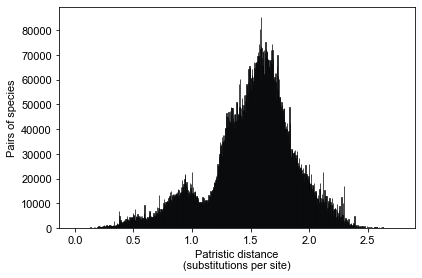

In [26]:
plt.figure()
plt.hist(dfm['pd_dist'], density = False, bins = 'auto',
        color = '#4c5c68', edgecolor = 'black', alpha = 0.7)
plt.ylabel('Pairs of species')
plt.xlabel('Patristic distance\n(substitutions per site)')
# plt.savefig('figures_all/tips_dist.svg')
plt.show()

Scatter plots

In [27]:
seed = 42

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
def polyReg(degree = 2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [30]:
param_grid = {'polynomialfeatures__degree': np.arange(4)}

**Arcsine transformation for proportional data**

In [31]:
dfm_sample['diff_log_svratio_n1_arcsin'] = np.arcsin(np.sqrt(dfm_sample['diff_log_svratio_n1']))
dfm_sample['diff_log_svratio_n2_arcsin'] = np.arcsin(np.sqrt(dfm_sample['diff_log_svratio_n2']))
dfm_sample['diff_log_svratio_n3_arcsin'] = np.arcsin(np.sqrt(dfm_sample['diff_log_svratio_n3']))

In [32]:
dfm['diff_log_svratio_n1_arcsin'] = np.arcsin(np.sqrt(dfm['diff_log_svratio_n1']))
dfm['diff_log_svratio_n2_arcsin'] = np.arcsin(np.sqrt(dfm['diff_log_svratio_n2']))
dfm['diff_log_svratio_n3_arcsin'] = np.arcsin(np.sqrt(dfm['diff_log_svratio_n3']))

**The three metrics used show a similar pattern. Metric 1 (`diff_log_svratio_n1`) saturates at 1 for pairs that have a large difference, whereas metrics 2 and 3 do not have that problem, but metric 3 cannot be arcsine transformed. I will use metric 2 ($\frac{\lvert a - b \rvert}{\text{max} - \text{min}}$) for subsequent analyses because it is easier to interpret**

### Multiple fit

In [33]:
def linear_func(x, a, b):
    return a * x + b

def polynomial_func(x, *coefficients):
    return np.polyval(coefficients, x)

def exponential_func(x, a, b):
    return a * np.exp(b * x)

def piecewise_linear_func(x, x0, y0, k1, k2):
    # Returns the 
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: k1 * x + y0 - k1 * x0, lambda x: k2 * x + y0 - k2 * x0])

def squared(x, a):
    return a * x ** 2

In [34]:
def curve_fitting(func, x, y):
    # Fit data to function
    if func == polynomial_func:
        coeffs, cov = curve_fit(func, x, y, [1, 0, 0])
    elif func == piecewise_linear_func:
        # Start paramaters
        coeffs, cov = curve_fit(func, x, y, [np.mean(x), np.mean(y), 1, 1])
    else:
        coeffs, cov = curve_fit(func, x, y)

    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = func(x, *coeffs)
    # Calculate stds
    std = np.sqrt(np.diag(cov))
    # Calculate confidence interval --needs adjustment
    y_lower = func(x_fit, (*coeffs - std))
    y_upper = func(x_fit, (*coeffs + std))
    
    return x_fit, y_fit, y_lower, y_upper, coeffs

**It is hard to distinguish a clear pattern among the cloud of points.**

Analizing the goodness of fit with $R^2$, which is easier although not all statisticians like to use $R^2$ as a measure of goodness of fit.

In [35]:
x, y = dfm['pd_dist'].to_numpy(), dfm['diff_log_svratio_n2_arcsin'].to_numpy()

In [36]:
colors = ['#26547c', '#ef476f', '#ffd166', '#2a9d8f']
labels = ['Linear', 'Polynomial', 'Exponential', 'Piecewise linear', 'Squared']
styles = ['solid', 'dotted', 'dashed', 'dashdot']

In [37]:
for i, func in enumerate([linear_func, polynomial_func, exponential_func, piecewise_linear_func, squared]):
    print(f'Function: {labels[i]}')
    x_fit, y_fit, y_lower, y_upper, coeffs = curve_fitting(func, x, y)
    # Residuals
    residuals = (y - y_fit) ** 2
    mse = np.sum(residuals) / len(x)
    # DO residuals follow a normal distribution?
    parameters = norm.fit(np.log10(residuals))
    gft = kstest(np.log10(residuals), 'norm', parameters)
    print(f'\tKolmogorov-Smirnov test for normality of residuals (P-value): {gft[1]:.2f}')
    # Calculate R^2
    r2 = 1 - np.sum(residuals) / np.sum((y - np.mean(y)) ** 2)
    print(f'\tMSE: {mse:.2f}, r2: {r2:.4f}')
    print(f'\tCoefficients: {coeffs}')

Function: Linear
	Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
	MSE: 0.02, r2: 0.0196
	Coefficients: [0.04805201 0.18444182]
Function: Polynomial
	Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
	MSE: 0.02, r2: 0.0238
	Coefficients: [ 0.03983071 -0.06332989  0.25640833]
Function: Exponential
	Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
	MSE: 0.02, r2: 0.0206
	Coefficients: [0.18933835 0.2004876 ]
Function: Piecewise linear
	Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
	MSE: 0.02, r2: 0.0352
	Coefficients: [1.87539412 0.25944541 0.02184732 0.26486042]
Function: Squared
	Kolmogorov-Smirnov test for normality of residuals (P-value): 0.00
	MSE: 0.02, r2: -0.4312
	Coefficients: [0.09237787]


Accroding to $R^2$ the best fit (only slightly better) to the data is the **Piecewise linear function.** 

**Parameters: slope_1 = 0.02, slope_2 = 0.26**

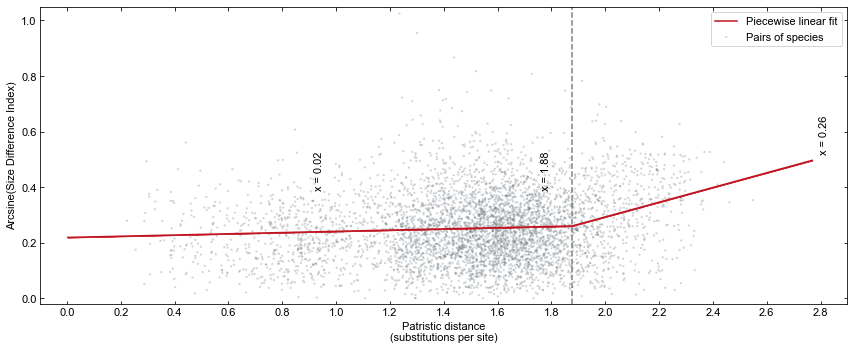

In [38]:
plt.figure(figsize = (12, 5))

# Fit to all the data pairs
x, y = dfm['pd_dist'].to_numpy(), dfm['diff_log_svratio_n2_arcsin'].to_numpy()

# For scatter plot, randomly sample n pairs of data points
plt.scatter(dfm_sample['pd_dist'], dfm_sample['diff_log_svratio_n2_arcsin'], color = '#6c757d', 
            alpha = 0.3, edgecolor = 'none', s = 5, label = 'Pairs of species')

# Fit--only the best fit according to R^2
for i, func in enumerate([piecewise_linear_func]):
    x_fit, y_fit, y_lower, y_upper, coeffs = curve_fitting(func, x, y)
    plt.plot(np.sort(x), np.sort(y_fit), color = '#c1121f', label = 'Piecewise linear fit')
    plt.fill_between(x_fit, y_lower, y_upper, color = '#c1121f', alpha = 0.8)

# Add parameters
plt.axvline(x = coeffs[0], color = 'grey', linestyle = 'dashed', alpha = 1.0)
# End of first piece
plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 1
plt.text(coeffs[0] * 0.5, coeffs[1] * 1.5, f'x = {coeffs[2]:.2f}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
# Slope 2
plt.text(coeffs[0] * 1.5, coeffs[1] * 2.0, f'x = {coeffs[3]:.2f}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
    
plt.xlabel('Patristic distance\n(substitutions per site)')
plt.ylabel('Arcsine(Size Difference Index)')
plt.legend()
plt.xticks(np.arange(0, 3, 0.2))
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.02, 1.05)
plt.xlim(-0.1, 2.9)

plt.savefig('../figures_all/pd_dist_svratio_all.svg')
plt.show()

Using a 2d histogeam instead of the cloud of points

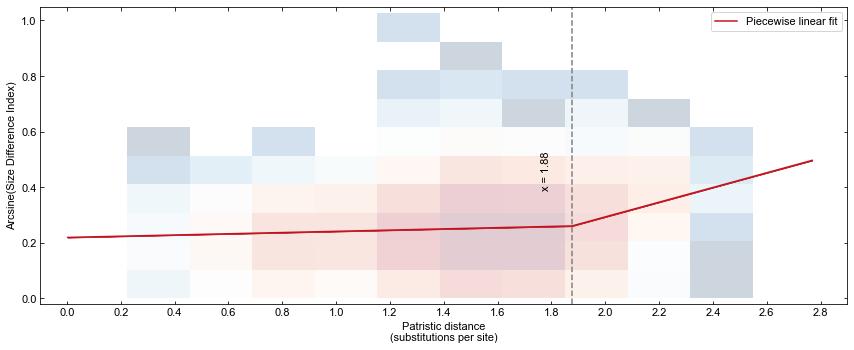

In [39]:
plt.figure(figsize = (12, 5))
x, y = dfm['pd_dist'].to_numpy(), dfm['diff_log_svratio_n2_arcsin'].to_numpy()

plt.hist2d(dfm_sample['pd_dist'], dfm_sample['diff_log_svratio_n2_arcsin'],
          cmap = 'RdBu_r', alpha = 0.2, norm = colorsm.LogNorm())

# Fit--only the best fit according to R^2
for i, func in enumerate([piecewise_linear_func]):
    x_fit, y_fit, y_lower, y_upper, coeffs = curve_fitting(func, x, y)
    plt.plot(np.sort(x), np.sort(y_fit), color = '#c1121f', label = 'Piecewise linear fit')
    plt.fill_between(x_fit, y_lower, y_upper, color = '#c1121f', alpha = 0.8)

plt.axvline(x = coeffs[0], color = 'grey', linestyle = 'dashed', alpha = 1.0)
plt.text(coeffs[0] * 0.95, coeffs[1] * 1.5, f'x = {coeffs[0]:.2f}', color = 'k',
        ha = 'center', va = 'bottom', rotation = 90)
    
plt.xlabel('Patristic distance\n(substitutions per site)')
plt.ylabel('Arcsine(Size Difference Index)')
plt.legend()
plt.xticks(np.arange(0, 3, 0.2))
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.02, 1.05)
plt.xlim(-0.1, 2.9)

# plt.savefig('figures_all/pd_dist_svratio_all.svg')
plt.show()

Note that the histogram of tip-to-tip distances resembles a bell curve, menaning that most pairs have a phylogenetic distance of $\sim 1.5$. **To increase the signal and obtain a statistical pattern, we will randomly sample an even number of points withing a given phylogenetic distance range (bin),**

In [40]:
bins = np.arange(0, 3, 0.2)
bins.shape

(15,)

In [41]:
bins

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8])

Find points within a given bin

In [42]:
pd_binidx = np.digitize(dfm['pd_dist'], bins)

In [43]:
pd_binidx.min(), pd_binidx.max()

(1, 14)

Note that sampled points between bin (index 1) and bin (index 11)

**Let's sample *k* data points within each bin (phylogenetic distance)**

In [44]:
k = 1000

In [45]:
binned = []
np.random.seed(42)
for i in range(len(bins)):
    # Get idx of points
    idx = np.where(pd_binidx == i + 1)[0]
    # Randomly sample k data points 
    binned.append(np.random.choice(idx, k, replace = False) if len(idx) > k else idx)
#     print(f'bin {i + 1}, n = {len(idx)}, n_sampled = {len(binned[i])}')

In [46]:
sampled_idx = np.concatenate(binned)

### Box plot per bin

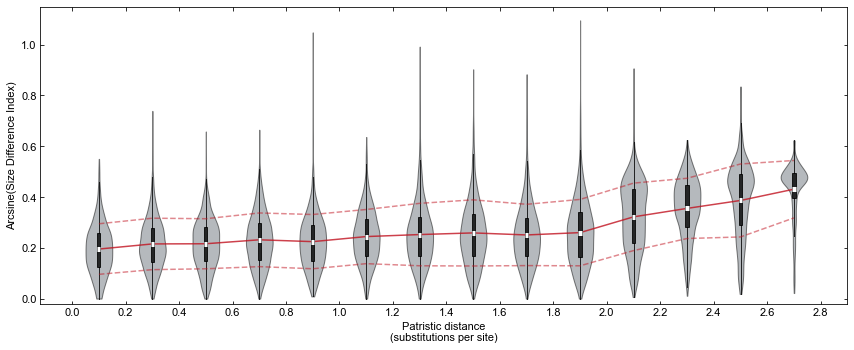

In [47]:
# plt.figure(figsize = (6, 4))
plt.figure(figsize = (12, 5))
data = [dfm['diff_log_svratio_n2_arcsin'].to_numpy()[binned[i]] for i in range(len(bins))]
data = [data[i] for i in range(len(data)) if len(data[i]) != 0]
parts = plt.violinplot(data, 
               showmedians = False, showextrema = False)

for pc in parts['bodies']:
    pc.set_facecolor('#6c757d')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

plt.boxplot(data, whis = None, showmeans = True, meanline = True,
            showcaps = False, widths = 0.06, patch_artist = True,
            boxprops = dict(color = 'k', facecolor = 'k', alpha = 0.8),
            whiskerprops = dict(color = 'k', linewidth = 1, alpha = 0.8),
            medianprops = dict(color = 'k', linewidth = 0.1, alpha = 0.1),
           meanprops = dict(color = 'w', linewidth = 5))

# Median and stds
plt.plot(np.arange(len(bins))[1:], [np.mean(d) for d in data], color = '#c1121f', alpha = 0.8)
plt.plot(np.arange(len(bins))[1:], [np.mean(d) + np.std(d) for d in data], 
         color = '#c1121f', alpha = 0.5, linestyle = 'dashed')
plt.plot(np.arange(len(bins))[1:], [np.mean(d) - np.std(d) for d in data], 
         color = '#c1121f', alpha = 0.5, linestyle = 'dashed')


plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5],
           [round(b, 2)for b in bins], rotation = 0, horizontalalignment = 'center')

#plt.title(f'$R^2 = {r2[0]:.2f}$, $p = {r2[1]:.4f}$')
plt.xlabel('Patristic distance\n(substitutions per site)')
plt.ylabel('Arcsine(Size Difference Index)')
plt.ylim(-0.02, 1.15)
plt.xlim(-0.1, 15)

plt.savefig('../figures_all/pd_dist_svratio_bin_violinplot.svg')
plt.show()

Another version that allows to see the overall pattern --and the increase in mean and standard deviation along the phylogenetic distance

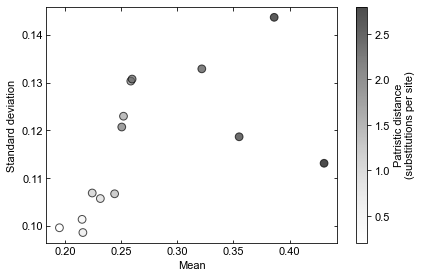

In [48]:
plt.figure()

x = [np.mean(d) for d in data]
y = [np.std(d) for d in data]
z = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5]

plt.scatter(x, y, c = bins[1:], cmap = 'Greys', s = 60, ec = 'k', alpha = 0.7)
cb = plt.colorbar()
cb.set_label('Patristic distance\n(substitutions per site)')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')

plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.savefig('../figures_all/pd_dist_svratio_bin_mean_std.svg')

plt.show()

## What patristic distance corresponds to taxonomic levels?

In [49]:
def diffLevel(a, b):
    for level in ['phylum', 'class', 'order', 'family', 'genus']:
        if df.loc[a][level] == df.loc[b][level]:
            if level == 'genus':
                return level
            else:
                continue
        else:
            return level

In [50]:
idx = df.index.tolist()

In [51]:
# %%time
# tax_dist = {'phylum': [], 'class': [], 'order': [], 'family': [], 'genus': []}
# for i, j in combinations(range(len(idx)), 2):
#     a = idx[i]
#     b = idx[j]/
#     level = diffLevel(a, b)
#     tax_dist[level].append(dm[a, b])

In [52]:
# %%time
# with open('tax_dist.csv', 'w') as f:
#     for k, v in tax_dist.items():
#         for val in v:
#             f.write(f'{k},{val}\n')

In [53]:
%%time
tax_dist = {}
with open('tax_dist.csv', 'r') as f:
    for line in f:
        k, v = line.strip().split(',')[0], float(line.strip().split(',')[1])
        if k not in tax_dist.keys():
            tax_dist[k] = [v]
        else:
            tax_dist[k].append(v)

CPU times: user 23.4 s, sys: 501 ms, total: 23.9 s
Wall time: 23.9 s


Sample 10k points for plot, otherwise is too expensive!

In [54]:
seed = 42
k_ = 10000
tax_dist_sample = {}
for k, v in tax_dist.items():
    tax_dist_sample[k] = np.random.choice(np.array(v), size = k_, replace = False)

In [55]:
def custom_boxplot(ax, data, positions, box_colors, labels):
    for pos, pdata, box_color, label in zip(positions, data, box_colors, labels):
        # Boxplot
        q1 = np.percentile(pdata, 25)
        q3 = np.percentile(pdata, 75)
        iqr = q3 - q1
        lower_whisker = np.min(pdata[pdata >= q1 - 1.5 * iqr])
        upper_whisker = np.max(pdata[pdata <= q3 + 1.5 * iqr])
        
        # Draw rectangle
        box_bottom = pos - 0.2
        box_top = pos + 0.2
        ax.fill_betweenx([box_bottom, box_top], q1, q3, color = box_color, alpha = 0.8)
        ax.fill_betweenx([box_bottom, box_top], q1, lower_whisker, color = box_color, alpha = 0.3)
        ax.fill_betweenx([box_bottom, box_top], q3, upper_whisker, color = box_color, alpha = 0.3)
        
        # Add labels in the middle of boxplot
        ax.text(q1 + (q3 - q1) / 2, pos, label, color = 'k', ha = 'center', va = 'center', fontsize = 13)


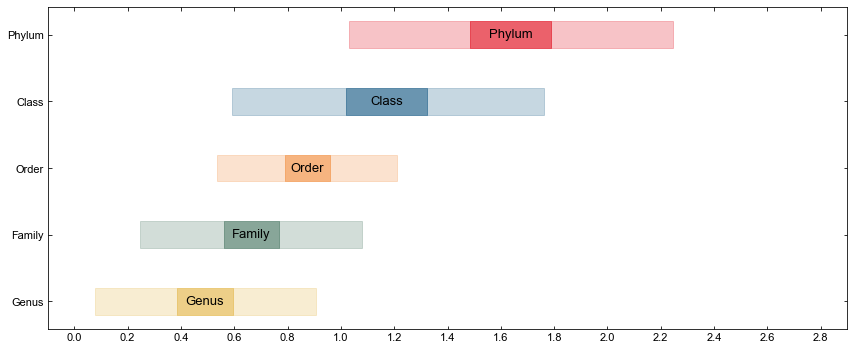

In [56]:
# Plot
box_colors = ['#e63946', '#457b9d', '#f4a261', '#6b9080', '#e9c46a']
fig, ax = plt.subplots(figsize = (12, 5))
labels, datum = [x.capitalize() for x in tax_dist_sample.keys()][::-1], list(tax_dist_sample.values())[::-1]
positions = np.arange(1, len(datum) + 1)
custom_boxplot(ax, datum, positions, box_colors[::-1], labels)

plt.yticks(range(1, len(labels) + 1), labels)
plt.xticks(np.arange(0, 3, 0.2))
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlim(-0.1, 2.9)
plt.savefig('../figures_all/tax_dist.svg')
plt.show()